In [ ]:
'''
Statistical analysis of the repetitions data
'''

In [38]:
from __future__ import print_function
import numpy as np
import scipy
import scipy.io as sio
import os
from os import listdir, mkdir, system
from os.path import join, isdir, basename, splitext
import pdb # debugger
import glob
from sklearn.model_selection import train_test_split
import librosa
import soundfile as sf
import math
import pandas as pd

# CONFIG
#########
htk_bin_dir = "htk/bin/linux/"; #HTK binaries
audio_dir = "data/imitative_agent_inner_speech/pb2007/overt/repeated" ; #"data/wav16" # audio data
corpus_mlf = "data/pb2007_speedx2_preprocessed_lab.mlf"; # "data/Thomas_lemonde_1_150_aligned.mlf"; ; # #phonetic segmentation of audio data 

train_test_ratio=0.0 # train/test data partioning
    
mfcc_config_file = "htk/config/mfcc.cnf"; # acoustic feature extraction 
phonelist = "data/phonelist"; # HMM list (aka list of phonemes)
hmm_proto = "models/proto"; # HMM topology 

nIte = 10; # number of iteration of the EM alggorithm (Baum-welch)

# decoding options (viterbi decoding)
dict_filename = "lm/dict_phones";
grammar = "lm/grammar_phones";
wip = -0; # model insertion penalty

# Make some noise! 
noise_filename = "data/babble16.wav";
target_snr = +40.; # in dB (warning, should be a float)

# First step : extract features, 2nd step : hmm_gmm
# Steps
step_add_noise_train = 0;
step_add_noise_test = 0;
step_extract_features = 1;
step_train = 0;
step_hmm_gmm = 0;
step_test = 0;

seed2 = 42 # for reproducibility

In [25]:
# FUNCTIONS DEFINITION

################
# SUBFUNCTIONS #
################
def do_extract_mfcc(all_audio_filenames, ind,target_scp_filename):
    if isdir("data/mfcc1/") is False:
        mkdir("data/mfcc1/")

    all_ind_audio_filenames = [all_audio_filenames[index] for index in ind]

    f = open(target_scp_filename,'w')
    for k in range(np.shape(all_ind_audio_filenames)[0]):
        audio_filename_no_root = basename(all_ind_audio_filenames[k])
        audio_basename = splitext(audio_filename_no_root)[0]
        f.write('data/mfcc1/' + audio_basename + '.mfcc\n')

        system(htk_bin_dir + '/HCopy -C ' + mfcc_config_file + ' ' +  all_ind_audio_filenames[k] + ' ' + 'data/mfcc1/' + audio_basename + '.mfcc');
        
    f.close()

############################################   

def do_train():
    # Computing variance floors
    print("Computing variance of all features (variance flooring)\n");
    if isdir("models/hmm_0")==False:
        mkdir("models/hmm_0"); 

    system(htk_bin_dir + "/HCompV -T 2 -f 0.01 -m -S " + "data/train.scp" + " -M models/hmm_0 -o models/average.mmf " + hmm_proto);
    
    # Generating hmm template
    system("head -n 1 " + hmm_proto + " > models/hmm_0/init.mmf");
    system("cat models/hmm_0/vFloors >> models/hmm_0/init.mmf");

    # HMM parameters estimation using Viterbi followed by Baum-welch (EM) alg.
    all_phones = [line.rstrip() for line in open(phonelist)]

    if isdir("models/hinit")==False:
        mkdir("models/hinit/");

    if isdir("models/hrest")==False:
        mkdir("models/hrest/");

    for p in range(np.shape(all_phones)[0]):
        print("===============" + all_phones[p] + "================\n");
        system(htk_bin_dir +"/HInit -T 000001 -A -H models/hmm_0/init.mmf -M models/hinit/ -I " + corpus_mlf + " -S " + "data/train.scp" + " -l "+ all_phones[p] + " -o " + all_phones[p] + " " + hmm_proto);
        system(htk_bin_dir + "/HRest -A -T 000001 -H models/hmm_0/init.mmf -M models/hrest/ -I " + corpus_mlf + " -S " + "data/train.scp" + " -l " + all_phones[p]+ " models/hinit/" + all_phones[p]);
        
    # Making monophone mmf
    # load variance floor macro
    f=open("htk/scripts/lvf.hed","w")
    f.write("FV \"models/hmm_0/vFloors\"\n");
    f.close();

    if isdir("models/herest_0")==False:
        mkdir("models/herest_0")

    system(htk_bin_dir + "/HHEd -d models/hrest/ -w models/herest_0/monophone.mmf htk/scripts/lvf.hed " + phonelist);

    # HMM parameter generation using embedded version of Baum-welch algorithm
    for i in range(nIte):
        if isdir("models/herest_" + str(i+1))==False:
            mkdir("models/herest_" + str(i+1))
	
        # embedded reestimation
        system(htk_bin_dir + "/HERest -A -I " + corpus_mlf + " -S " + "data/train.scp" + " -H models/herest_" + str(i) + "/monophone.mmf -M models/herest_" + str(i+1) + " " + phonelist);

        # Make a copy of last model parameters
        system("cp models/herest_" + str(i+1) + "/monophone.mmf models/herest_" + str(i+1) + "/monophone_gmm.mmf")

    if step_hmm_gmm:
        # Increase number of gaussians per state up to 2
        f = open("./hhed.cnf","w");
        f.write("MU %i {*.state[2-4].mix}\n" % 2);
        f.close()

        system(htk_bin_dir + "/HHEd -A -H models/herest_" + str(i+1) + "/monophone_gmm.mmf ./hhed.cnf " + phonelist);
    
        # Re-estimate model parameters (let's do 5 iterations of EM)
        for r in range (5):
            system(htk_bin_dir + "/HERest -T 0 -S " + "data/train.scp" + " -H models/herest_" + str(i+1) + "/monophone_gmm.mmf -I " + corpus_mlf + " " + phonelist)
        
            # ... up to 4
            f = open("./hhed.cnf","w");
            f.write("MU %i {*.state[2-4].mix}\n" % 4);
            f.close()

            system(htk_bin_dir + "/HHEd -A -H models/herest_" + str(i+1) + "/monophone_gmm.mmf ./hhed.cnf " + phonelist);

            # Again, we re-estimate model parameters (let's do 5 iterations of EM)
            for r in range (5):
                system(htk_bin_dir + "/HERest -A -T 0 -S " + "data/train.scp" + " -H models/herest_" + str(i+1) + "/monophone_gmm.mmf -I " + corpus_mlf + " " + phonelist)   
############################################
def do_test():
    # convert grammar rules to decoding network
    system(htk_bin_dir + "/HParse -A " + grammar + " lm/wnet")
    dataset= audio_dir.split('/')[1:-1]
    # phonetic decoding using Viterbi algorithm (Token Passing)
    system(htk_bin_dir + "/HVite -A -y rec -p " + str(0.0) + " -m -T 1 -S " + "data/test1.scp" + " -H models/herest_" + str(nIte) + f"/monophone_gmm.mmf -i data/rec.mlf -w lm/wnet " + dict_filename + " " + phonelist)

    # Calculate WER    str(wip) 
    x = system(htk_bin_dir + "/HResults -A -X lab -s -t -f -p -I " + corpus_mlf + " " + phonelist + " data/rec.mlf")
    print(f'the HResult return is {x}')

##############################################

def add_noise(all_audio_filenames,audio_dir_noise,noise_filename,target_snr):
    if isdir(audio_dir_noise) is False:
        mkdir(audio_dir_noise)

    y_noise,sr_noise = librosa.load(noise_filename, sr=None)
    #all_ind_audio_filenames = [all_audio_filenames[index] for index in ind]

    for k in range(np.shape(all_audio_filenames)[0]):
        audio_filename_no_root = basename(all_audio_filenames[k])
        audio_basename = splitext(audio_filename_no_root)[0]
        
        y, sr = librosa.load(all_audio_filenames[k],sr=None)
        rms_y = math.sqrt(np.mean(y**2))

        noise_part = y_noise[range(np.shape(y)[0])]
        rms_noise = math.sqrt(np.mean(noise_part**2))
        target_rms_noise = np.sqrt((rms_y**2)/(10**(target_snr/10)))

        #current_snr = 10*np.log10((rms_y**2)/(rms_noise**2))
        #print("(initial) RMS_noise=%.2f, RMS_signal=%.2f, SNR = %.2f\n, RMS_noise_target=%.2f" % (rms_noise,rms_y,current_snr,target_rms_noise));
        
        while rms_noise>target_rms_noise :
            noise_part = 0.99*noise_part 
            rms_noise = math.sqrt(np.mean(noise_part**2))
            current_snr = 10*np.log10((rms_y**2)/(rms_noise**2))
            #print("RMS_noise=%.3f, RMS_signal=%.3f, SNR = %.3f\n" % (rms_noise,rms_y,current_snr));
 
        y_plus_noise = y + noise_part;
        current_snr = 10*np.log10((rms_y**2)/(rms_noise**2))
        #print("(final) RMS_noise=%.2f, RMS_signal=%.2f, SNR = %.2f\n" % (rms_noise,rms_y,current_snr));
        sf.write(audio_dir_noise + '/'+ audio_basename + '.wav',y_plus_noise,sr);

############################################
def HTKWrite(fname, data, sampPeriod):
	nSamples = np.shape(data)[0]
	nFeatures = np.shape(data)[1]

	sampSize = nFeatures * 4
	paramKind = 9  # USER
	
	f = open(fname, 'wb')
	
	# Write header
	f.write(struct.pack('i', nSamples))
	f.write(struct.pack('i', sampPeriod))
	f.write(struct.pack('h', sampSize))
	f.write(struct.pack('h', paramKind))

	# Write data
	data.astype(float32).tofile(f)
	
	f.close()

############################################
def HTKRead(fname):
    f = open(fname, 'rb')
    
    nSamples = np.fromfile(f, 'i', 1, "")
    sampPeriod = np.fromfile(f, 'i', 1, "")  
    sampSize = np.fromfile(f, 'h', 1, "") 
    paramKind = np.fromfile(f, 'h',1, "") 

    nFeatures = sampSize/4

    # Read data
    data_vect  = np.fromfile(f,'f',nFeatures*nSamples,"") 
    data = data_vect.reshape((nSamples, nFeatures))
    f.close()
    
    return data

In [39]:
# PHONEME DECODING PIPELINE

N = 1 # number of repetitions test

# Split dataset into train and test set
all_audio_filenames = glob.glob(audio_dir + '/*.wav')
#train_ind, test_ind = train_test_split(range(np.shape(all_audio_filenames)[0]), train_test_ratio, random_state=seed2)
test_ind = range(np.shape(all_audio_filenames)[0])
train_ind = []
if step_add_noise_train | step_add_noise_test:
    print("Adding babble noise to clean audio ...\t");
    add_noise(all_audio_filenames,'data/wav16_noise',noise_filename,target_snr);
    print("Done\n");

if step_extract_features:
    if step_add_noise_train:
        print("Extracting MFCC (noisy train set) ...\t");
        do_extract_mfcc(glob.glob('data/wav16_noise/*.wav'), train_ind, 'data/train1.scp');
        print("Done\n");
    else: 
        print("Extracting MFCC (train set) ...\t");
        do_extract_mfcc(all_audio_filenames, train_ind, 'data/train1.scp');
        print("Done\n");

    if step_add_noise_test:
        print("Extracting MFCC (noisy test set) ...\t");
        do_extract_mfcc(glob.glob('data/wav16_noise/*.wav'), test_ind, 'data/test1.scp');
        print("Done\n");
    else:
        print("Extracting MFCC (test set) ...\t");
        do_extract_mfcc(all_audio_filenames, test_ind, 'data/test1.scp');
        print("Done\n");
    
if step_train:
    do_train();

if step_test:
    do_test();

Extracting MFCC (train set) ...	
Done

Extracting MFCC (test set) ...	
Done



In [40]:
# PIPELINE TO CREATE MULTIPLE CONFUSION MATRICES FOR DIFFERENT REPETITIONS
N=1

for i in range(N):
    dataset = 'imitative_agent_inner_speech/pb2007/overt/repeated'

    audio_dir = f"data/{dataset}" ; #"data/wav16" # audio data
    corpus_mlf = "data/pb2007_lab.mlf"; # "data/Thomas_lemonde_1_150_aligned.mlf"; ; # #phonetic segmentation of audio data 
    save_dir = f'data/confusion_matrix_24_09/pb2007_overt_repetitions/cm_{i}'
    do_test()
    
    path_pred_labels = f'./data/rec.mlf'
    pred_labels = read_mlf(path_pred_labels)

    path_true_labels = './data/pb2007_preprocessed_lab.mlf'
    true_labels = read_mlf(path_true_labels)

    print(f'pred_labels is {pred_labels} \n of shape {len(pred_labels)}, \n true_labels is {true_labels} \n of shape {len(true_labels)}')


htk/bin/linux//HParse -A lm/grammar_phones lm/wnet 
htk/bin/linux//HVite -A -y rec -p 0.0 -m -T 1 -S data/test1.scp -H models/herest_10/monophone_gmm.mmf -i data/rec.mlf -w lm/wnet lm/dict_phones data/phonelist 
Read 36 physical / 36 logical HMMs
Read lattice with 40 nodes / 108 arcs
Created network with 79 nodes / 147 links
File: data/mfcc1/item_0000.mfcc
__ p a __  ==  [122 frames] -40.1589 [Ac=-4899.4 LM=0.0] (Act=74.7)
File: data/mfcc1/item_0001.mfcc
__ p e^ q __  ==  [130 frames] -39.2095 [Ac=-5097.2 LM=0.0] (Act=74.8)
File: data/mfcc1/item_0002.mfcc
__ e __  ==  [130 frames] -41.5387 [Ac=-5400.0 LM=0.0] (Act=74.8)
File: data/mfcc1/item_0003.mfcc
__ i n i __  ==  [122 frames] -42.3559 [Ac=-5167.4 LM=0.0] (Act=74.7)
File: data/mfcc1/item_0004.mfcc
__ y __  ==  [118 frames] -41.7074 [Ac=-4921.5 LM=0.0] (Act=74.6)
File: data/mfcc1/item_0005.mfcc
__ u u m __  ==  [110 frames] -42.1418 [Ac=-4635.6 LM=0.0] (Act=74.4)
File: data/mfcc1/item_0006.mfcc
__ o^ x x~ r x~ o^ __  ==  [114 frames

  ERROR [+6510]  LoadMasterFile: cannot open MLF data/pb2007_lab.mlf
 FATAL ERROR - Terminating program htk/bin/linux//HResults


pred_labels is {'item_0000': ['__', 'p', 'a', '__'], 'item_0001': ['__', 'p', 'e^', 'q', '__'], 'item_0002': ['__', 'e', '__'], 'item_0003': ['__', 'i', 'n', 'i', '__'], 'item_0004': ['__', 'y', '__'], 'item_0005': ['__', 'u', 'u', 'm', '__'], 'item_0006': ['__', 'o^', 'x', 'x~', 'r', 'x~', 'o^', '__'], 'item_0007': ['__', 't', 'x', '__'], 'item_0008': ['__', 'p', 'x^', '__'], 'item_0009': ['__', 'p', 'e^', 'r', '__'], 'item_0010': ['__', 'p', 'x^', 'a', '__'], 'item_0011': ['__', 'o^', 'q', '__'], 'item_0012': ['__', 'a~', '__'], 'item_0013': ['__', 'e~', 'q', '__'], 'item_0014': ['__', 'p', 'a', 'x~', 'q', '__'], 'item_0015': ['__', 'o~', '__'], 'item_0016': ['__', 'o^', '__'], 'item_0017': ['__', 'x^', '__'], 'item_0018': ['__', 'a', 'p', 'a', '__'], 'item_0019': ['__', 'a', 'r', 't', 'a', 'q', '__'], 'item_0020': ['__', 'a', 'q', 'k', 'a', '__'], 'item_0021': ['__', 'a', 'f', 'a', '__'], 'item_0022': ['__', 'p', 'a', 's', 'a', '__'], 'item_0023': ['__', 't', 'a', 's^', 'a', '__'], 

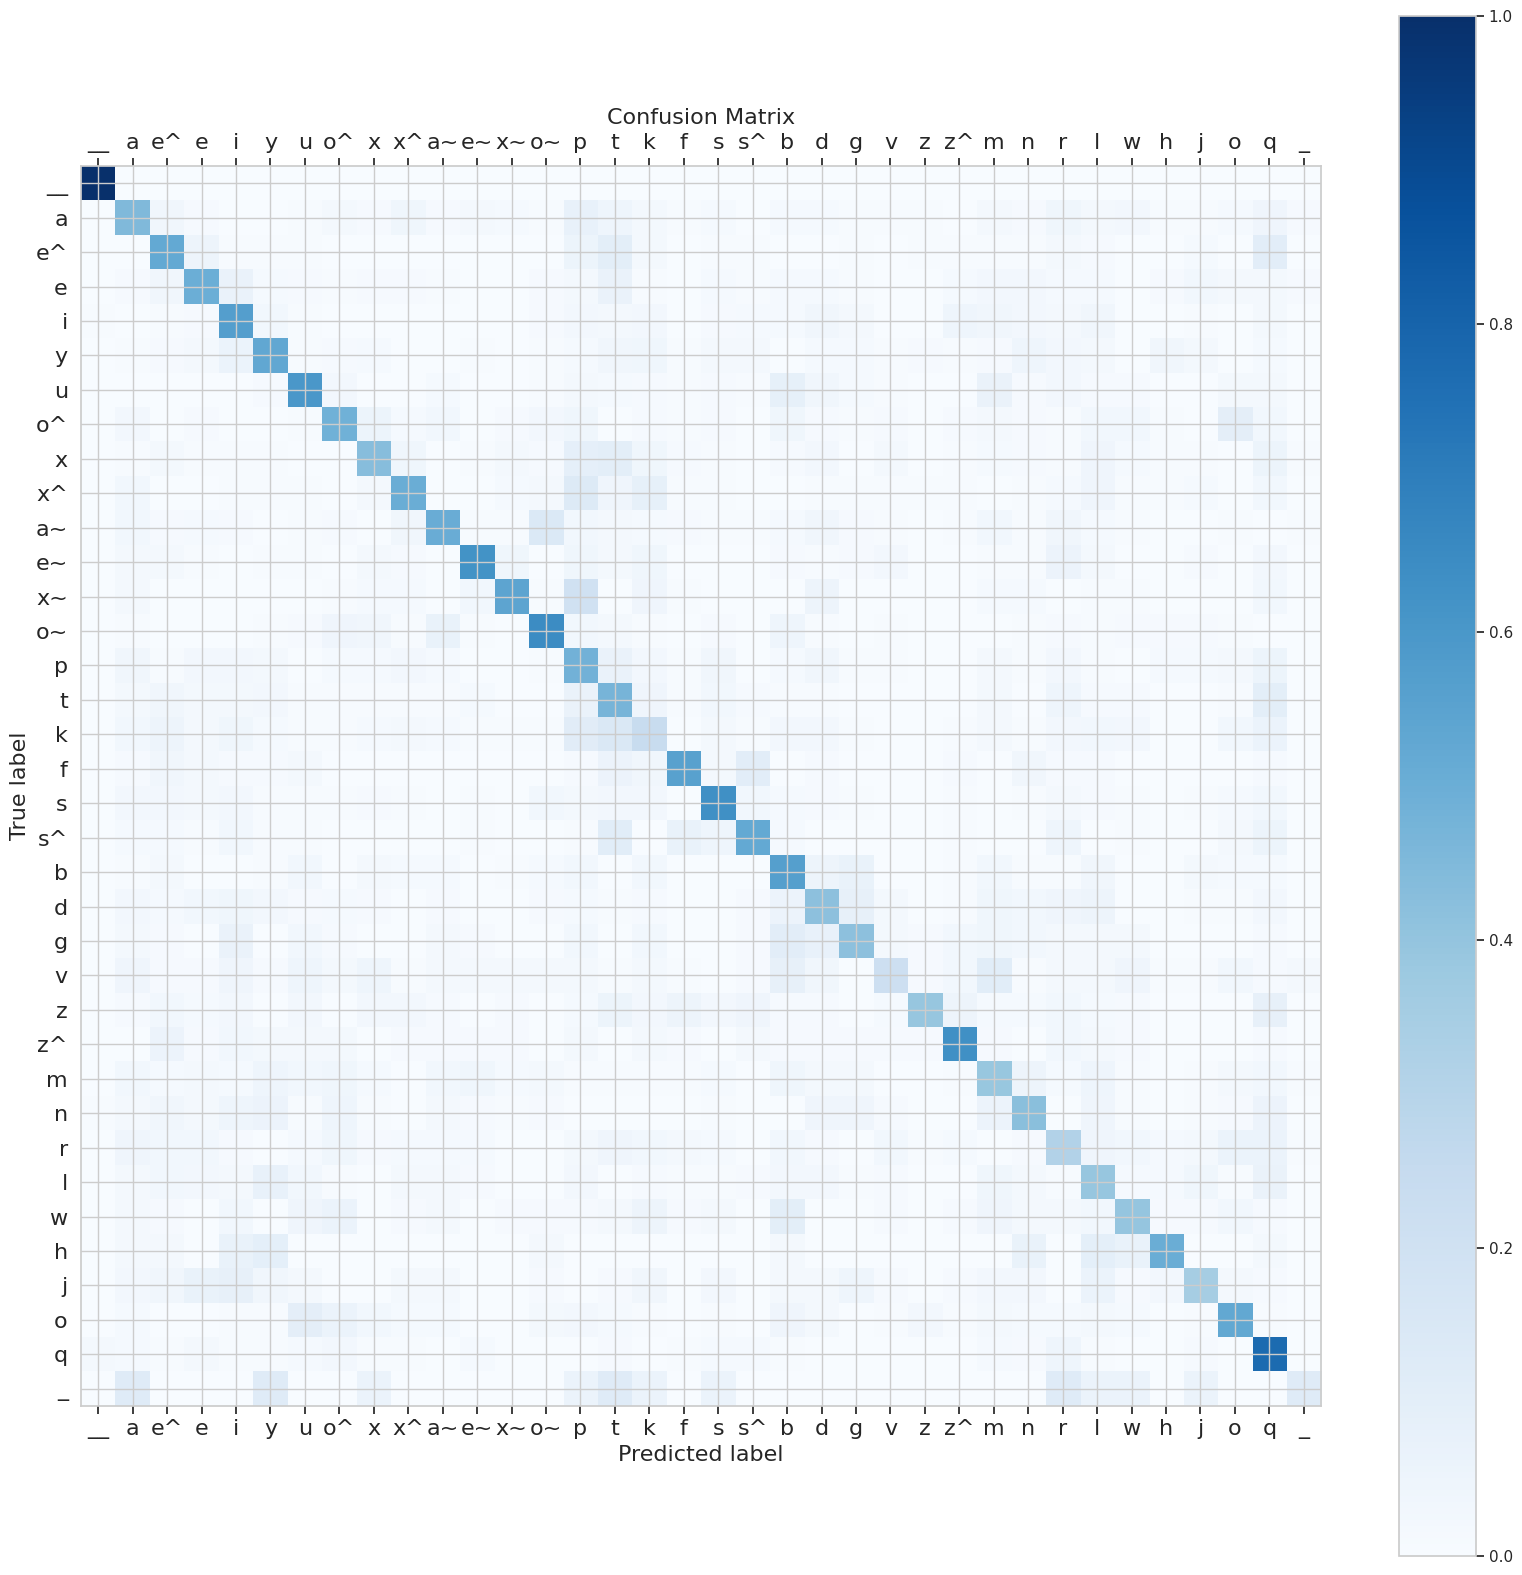

In [57]:
'''
Dictionnary of labels
'''

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def read_mlf(path):
    item_labels = {}
    current_item = None
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('"') and (line.endswith('.rec"') or line.endswith('.lab"')):
                # New item starts, extract the item name from the line
                current_item = line.strip('"').split('/')[-1].removesuffix('.rec').removesuffix('.lab')
                item_labels[current_item] = []
            elif line == '.':
                # End of current item, reset current item
                current_item = None
            else:
                # Process phonemic label lines
                parts = line.split()
                if len(parts) >= 3 and current_item is not None:
                    try:
                        # Convert the first two elements to ensure they are timestamps
                        start_time = int(parts[0])
                        end_time = int(parts[1])
                        # Append the label part to the current item's list
                        item_labels[current_item].append(parts[2])
                    except ValueError:
                        # If conversion fails, skip this line
                        continue
    return item_labels

# Example usage
path_pred_labels = './data/rec.mlf'
pred_labels = read_mlf(path_pred_labels)

path_true_labels = './data/pb2007_preprocessed_lab.mlf'
true_labels = read_mlf(path_true_labels)

print(f'pred_labels is {pred_labels} \n of shape {len(pred_labels)}, \n true_labels is {true_labels} \n of shape {len(true_labels)}')


def plot_confusion_matrix(path_pred,path_true, save_dir='path_to_save_directory'):
    y_true = read_mlf(path_true)
    y_pred = read_mlf(path_pred)
    labels_true, labels_pred = {}, {}
    count = 0
    for item in y_true:
        # if count < 100 : 
        item = item.split('/')[-1].removesuffix('.rec')
        i=0
        # Check if y_true[item] exist
        if item in y_pred.keys():
            while len(y_true[item]) < len(y_pred[item]): #We have len(y_pred[item]) > len(y_true[item])
                print(f'Warning: Length mismatch for item {item} ({len(y_true[item])} vs {len(y_pred[item])})')
                if y_true[item][i] != y_pred[item][i]:
                    print(f' rank {i}  {y_true[item][i]} vs {y_pred[item][i]}')
                    if y_true[item][i] != "_" and y_true[item][i] != "__":
                        y_true[item] = y_true[item][:i] + [y_true[item][i]] + y_true[item][i:]
                    else:
                        y_true[item] = y_true[item][:i] + [y_true[item][i-1]] + y_true[item][i:]
                i+=1
            k=0
            while len(y_true[item]) > len(y_pred[item]): #We have len(y_pred[item]) < len(y_true[item])
                print(f'Warning: Length mismatch for item {item} ({len(y_true[item])} vs {len(y_pred[item])})')
                if y_pred[item][k] != y_true[item][k]:
                    print(f' rank {k}  {y_true[item][k]} vs {y_pred[item][k]}')
                    y_pred[item] = y_pred[item][:k] + [y_pred[item][k]] + y_pred[item][k:]
                k+=1
            labels_true[item] = y_true[item]
            labels_pred[item] = y_pred[item]
                # count+=1
        
    print(f'labels_true is {labels_true} \n of shape {len(labels_true)}, \n labels_pred is {labels_pred} \n of shape {len(labels_pred)}')
    y_true = [label for item in labels_true for label in labels_true[item]]
    y_pred = [label for item in labels_pred for label in labels_pred[item]]
    labels = [
        "__", "a", "e^", "e", "i", "y", "u", "o^", "x", "x^", "a~", "e~", "x~", "o~", 
        "p", "t", "k", "f", "s", "s^", "b", "d", "g", "v", "z", "z^", "m", "n", 
        "r", "l", "w", "h", "j", "o", "q", "_"
    ]
    print(f'y_true is {y_true} \n of shape {len(y_true)}, \n y_pred is {y_pred} \n of shape {len(y_pred)}')

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Save confusion matrix to excel

    os.makedirs(save_dir, exist_ok=True)

    df_cm = pd.DataFrame(cm_normalized, index=labels, columns=labels)
    df_cm.to_excel(f'{save_dir}/confusion_matrix.xlsx')


    
    # Print reports
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print('Normalized Confusion Matrix:\n', cm_normalized)

    # Plotting
    fig, ax = plt.subplots(figsize=(20, 20))
    cax = ax.matshow(cm_normalized, cmap=plt.cm.Blues)  # use normalized matrix here
    fig.colorbar(cax)

    # Setting axis labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.tick_params(axis='x', bottom=True, labelbottom = True)
    ax.set_xticklabels(labels, fontsize = 16)
    ax.set_yticklabels(labels, fontsize = 16)

    # Annotating the heatmap with text for better readability
    # for i in range(len(labels)):
    #     for j in range(len(labels)):
    #         ax.text(j, i, f'{cm_normalized[i, j]:.2f}', ha="center", va="center",
    #                 color="white" if cm_normalized[i, j] > cm_normalized.max() / 2 else "black")

    ax.set_xlabel('Predicted label', fontsize = 16)
    ax.set_ylabel('True label', fontsize = 16)
    plt.title('Confusion Matrix', fontsize = 16)
    plt.show()

plot_confusion_matrix(path_pred_labels,path_true_labels,save_dir=f'data/confusion_matrix/imitative_agent_0jerk/repeated/pb2007_speedx2/')  # f'data/confusion_matrix/{dataset}/cm_1'

# path_A = 'data/confusion_matrix/imitative_agent_0jerk/repeated/pb2007/cm_0.xlsx'
# path_B = 'data/confusion_matrix/imitative_agent_0jerk/repeated/pb2007_speedx2/cm_0.xlsx'
    

In [35]:
!pip install varname

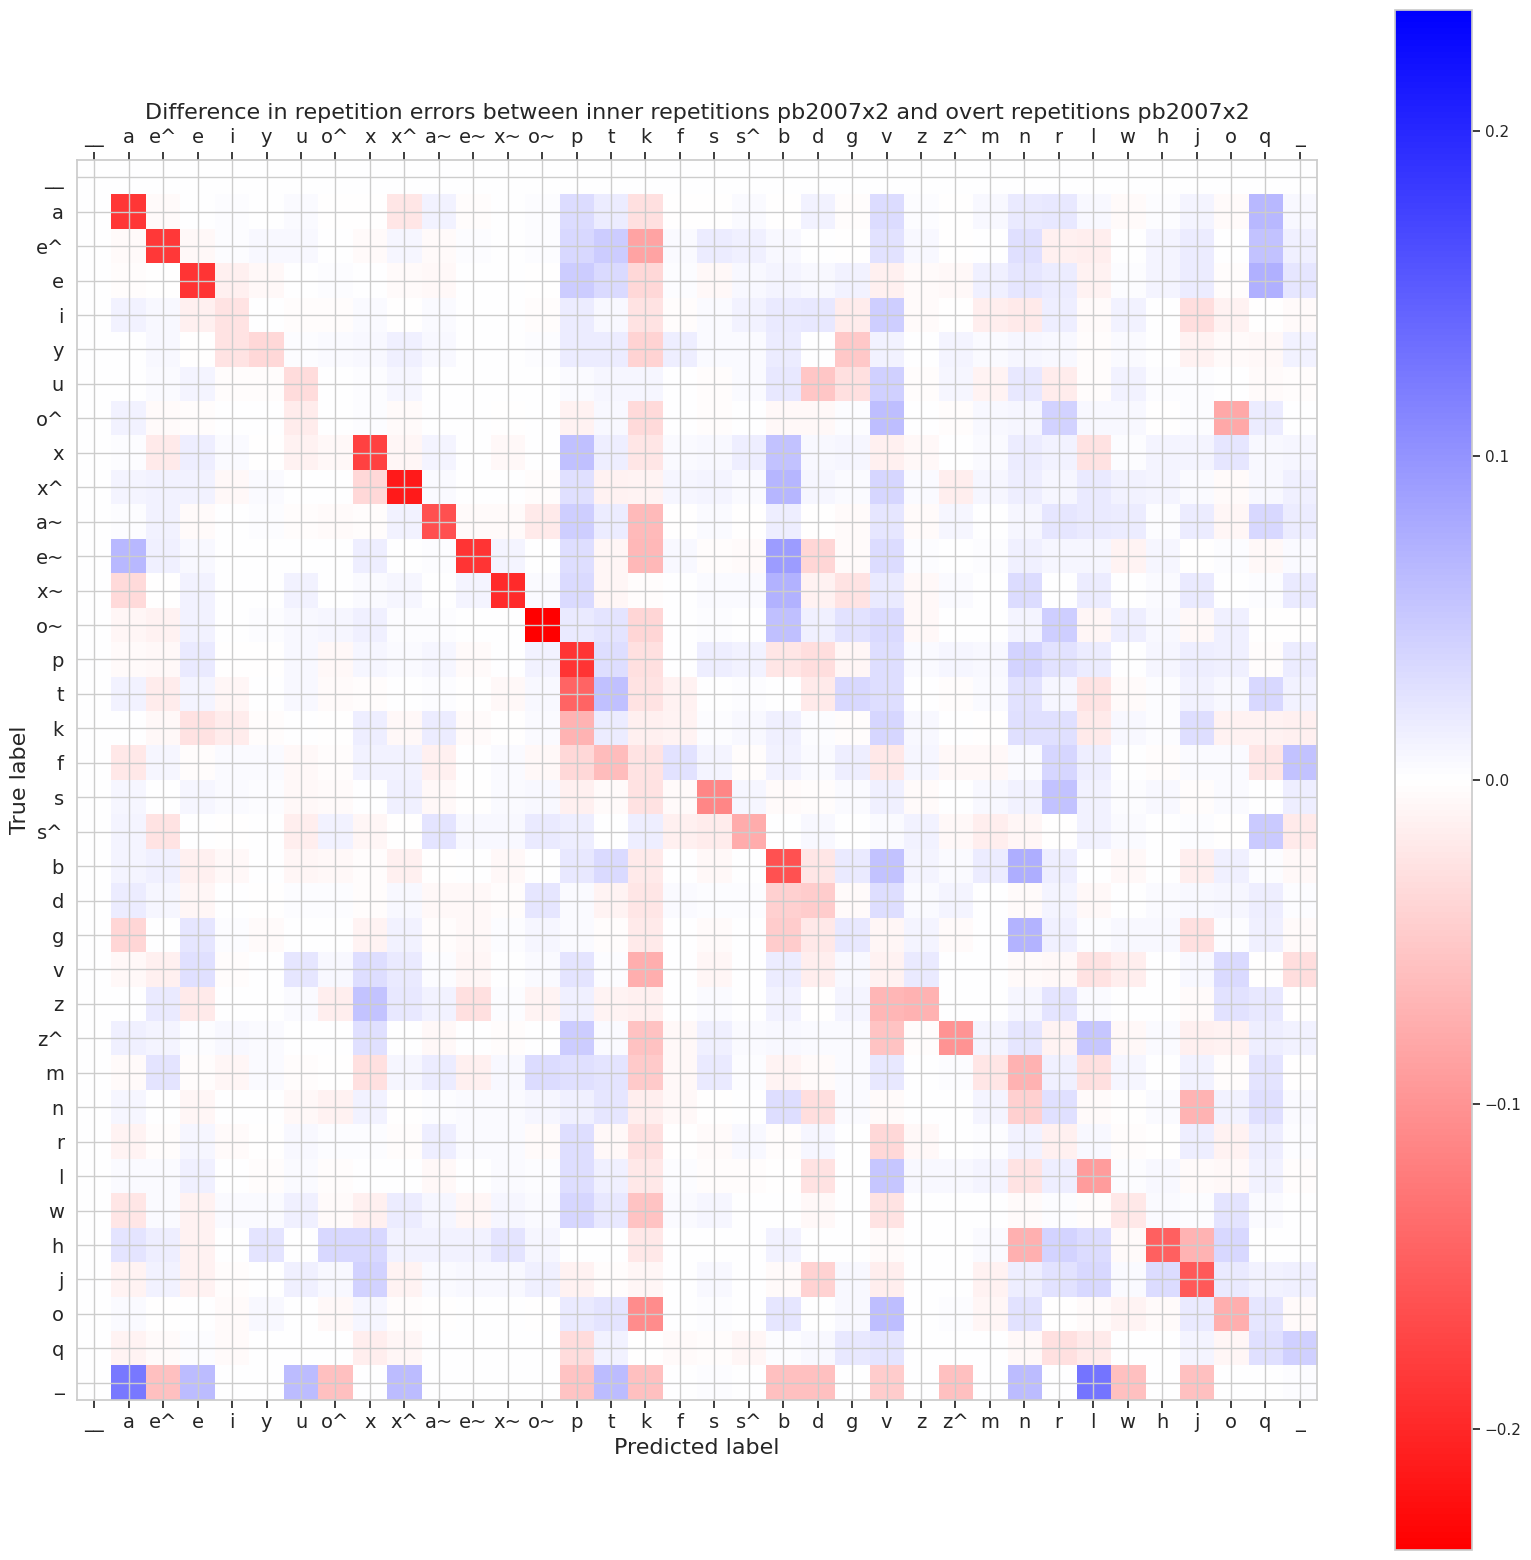

In [60]:
''' Plot difference of confusion matrix between 2 agents '''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from varname import nameof



# Paths setup (assuming you are iterating over multiple matrices later)
# path_A = 'data/confusion_matrix/pb2007/cm_{index}.xlsx'
# path_B = 'data/confusion_matrix/communicative_agent/repeated/pb2007/cm_{index}.xlsx'
# path_C = 'data/confusion_matrix/communicative_agent/repeated/pb2007_speedx2/cm_{index}.xlsx'


path_A = 'data/confusion_matrix/communicative_agent_0jerk/repeated/pb2007/cm_0.xlsx'
path_B = 'data/confusion_matrix/communicative_agent_0jerk/repeated/pb2007_speedx2/cm_0.xlsx'

# Load matrices (example for one set, loop over multiple sets in practice)
def load_matrix(path, index):
    # return pd.read_excel(path.format(index=index), index_col=0).to_numpy()
    return pd.read_excel(path, index_col =0).to_numpy()

# Function to create a symmetric red-white-blue colormap
def create_colormap():
    # Colors for negative values (red), zero (white), and positive values (blue)
    red = np.array([1, 0, 0, 1])   # RGBA for red
    white = np.array([1, 1, 1, 1]) # RGBA for white
    blue = np.array([0, 0, 1, 1])  # RGBA for blue

    # Color dictionary for linear gradient filling
    cdict = {'red':   [(0.0,  red[0], red[0]),
                       (0.5,  white[0], white[0]),
                       (1.0,  blue[0], blue[0])],

             'green': [(0.0,  red[1], red[1]),
                       (0.5,  white[1], white[1]),
                       (1.0,  blue[1], blue[1])],

             'blue':  [(0.0,  red[2], red[2]),
                       (0.5,  white[2], white[2]),
                       (1.0,  blue[2], blue[2])],

             'alpha': [(0.0,  red[3], red[3]),
                       (0.5,  white[3], white[3]),
                       (1.0,  blue[3], blue[3])]}

    return LinearSegmentedColormap('RedWhiteBlue', segmentdata=cdict)


# Assuming matrices are stored for 10 different trials
num_trials = 1
all_diff_A_B = []
all_diff_A_C = []
all_diff_B_C = []
cm_A = load_matrix(path_A, 0) # Exist a single matrix for the original data

for i in range(num_trials):
    i = 1
    cm_A = load_matrix(path_A, i)
    cm_B = load_matrix(path_B, i)
    # cm_C = load_matrix(path_C, i)

    # Compute differences
    all_diff_A_B.append(cm_A - cm_B)
    # all_diff_A_C.append(cm_A - cm_C)
    # all_diff_B_C.append(cm_B - cm_C)

# Convert lists to numpy arrays for easier manipulation
all_diff_A_B = np.array(all_diff_A_B)
# all_diff_A_C = np.array(all_diff_A_C)
# all_diff_B_C = np.array(all_diff_B_C)
# Compute average differences
avg_diff_A_B = np.mean(all_diff_A_B, axis=0)
# avg_diff_A_C = np.mean(all_diff_A_C, axis=0)
# avg_diff_B_C = np.mean(all_diff_B_C, axis=0)

labels = [
        "__", "a", "e^", "e", "i", "y", "u", "o^", "x", "x^", "a~", "e~", "x~", "o~", 
        "p", "t", "k", "f", "s", "s^", "b", "d", "g", "v", "z", "z^", "m", "n", 
        "r", "l", "w", "h", "j", "o", "q", "_"
    ]


# Plotting

matrix_to_plot, name= avg_diff_A_B , nameof(avg_diff_A_B)
# Create custom colormap
newcmp = create_colormap()
# Determine the range for the color scale to be symmetric around zero
vmax = max(-np.min(matrix_to_plot), np.max(matrix_to_plot))
vmin = -vmax
fig, ax = plt.subplots(figsize=(20, 20))
cax = ax.matshow(matrix_to_plot, cmap=newcmp,vmin=vmin,vmax=vmax)  # use normalized matrix here
fig.colorbar(cax)

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.tick_params(axis='x', bottom=True, labelbottom = True)
ax.set_xticklabels(labels, fontsize = 14)
ax.set_yticklabels(labels, fontsize = 14)



ax.set_xlabel('Predicted label', fontsize = 16)
ax.set_ylabel('True label', fontsize = 16)
# plt.title(f'Difference in repetition error between matrices {name[-3]} and {name[-1]} : {name} ', fontsize = 16)
plt.title(f'Difference in repetition errors between inner repetitions pb2007x2 and overt repetitions pb2007x2', fontsize = 16)
plt.show()

Weighted average error rate for inner speech: 0.6753
Weighted average error rate for overt speech: 0.5558
Difference (overt - inner): -0.1194


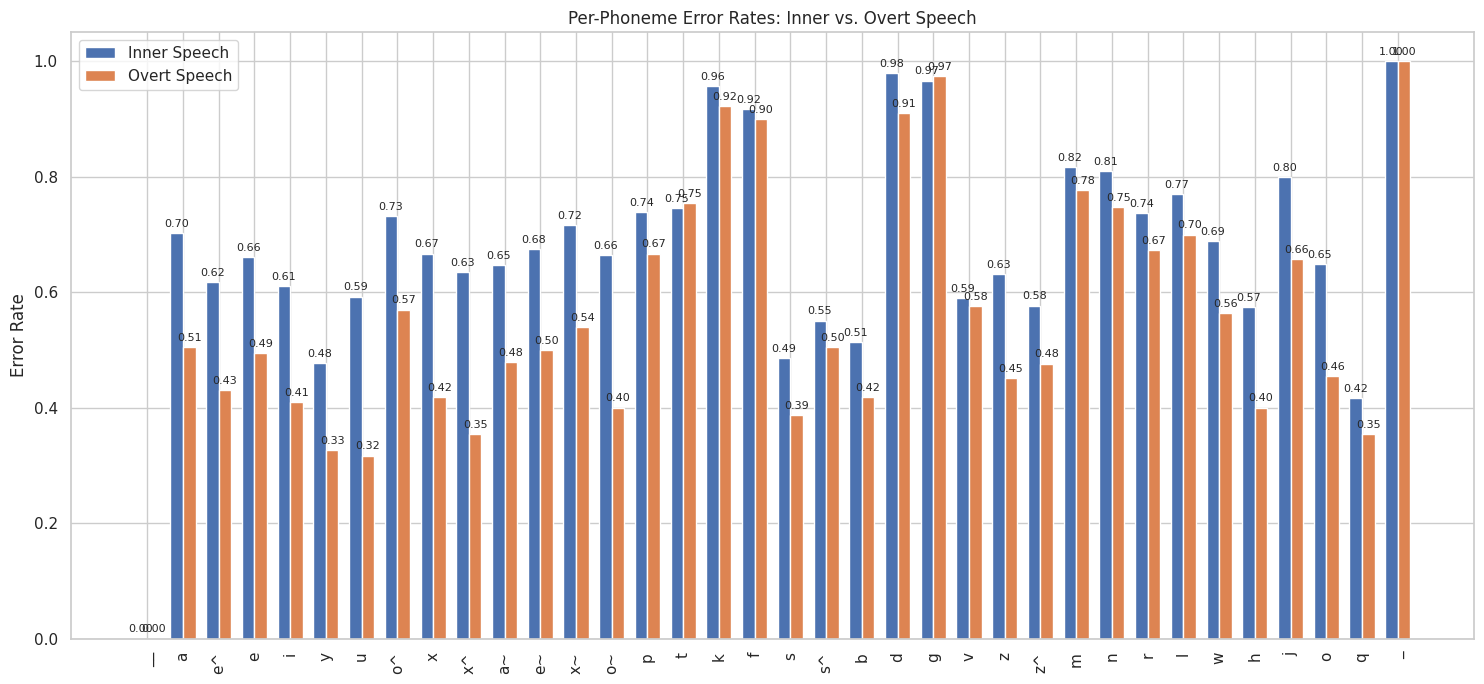

In [55]:
#################################
# Error rates #
###############


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paths setup
# path_inner = 'data/confusion_matrix_24_09/pb2007_speedx2_inner_estimations/cm_1/confusion_matrix.xlsx'
# path_overt = 'data/confusion_matrix_24_09/pb2007_speedx2_overt_repetitions/cm_1/confusion_matrix.xlsx'


path_inner = 'data/confusion_matrix/imitative_agent_0jerk/repeated/pb2007/cm_0.xlsx'
path_overt = 'data/confusion_matrix/imitative_agent_0jerk/repeated/pb2007_speedx2/cm_0.xlsx'

# Load matrices
def load_matrix(path):
    return pd.read_excel(path, index_col=0).to_numpy()

cm_inner = load_matrix(path_inner)
cm_overt = load_matrix(path_overt)

# Labels for phonemes
labels = [
    "__", "a", "e^", "e", "i", "y", "u", "o^", "x", "x^", "a~", "e~", "x~", "o~",
    "p", "t", "k", "f", "s", "s^", "b", "d", "g", "v", "z", "z^", "m", "n",
    "r", "l", "w", "h", "j", "o", "q", "_"
]

# Compute error rates
def compute_error_rates(cm):
    """
    Compute per-phoneme error rates from a confusion matrix.

    Parameters:
        cm (np.ndarray): Confusion matrix (2D numpy array)

    Returns:
        error_rates (np.ndarray): Array of error rates for each phoneme
        total_occurrences (np.ndarray): Total occurrences of each phoneme
    """
    total_occurrences = np.sum(cm, axis=1)
    correct_predictions = np.diag(cm)
    errors = total_occurrences - correct_predictions
    with np.errstate(divide='ignore', invalid='ignore'):
        error_rates = np.where(total_occurrences > 0, errors / total_occurrences, 0)
    return error_rates, total_occurrences

error_rates_inner, total_occurrences_inner = compute_error_rates(cm_inner)
error_rates_overt, total_occurrences_overt = compute_error_rates(cm_overt)

# Allow the user to set equal weights or use actual frequencies
use_equal_weights = True  # Set to False to use phoneme frequencies as weights

if use_equal_weights:
    weights = np.ones(len(labels))
else:
    # Use average total occurrences as weights (phoneme frequencies)
    weights = (total_occurrences_inner + total_occurrences_overt) / 2

def compute_weighted_average_error_rate(error_rates, weights):
    """
    Compute the weighted average error rate.

    Parameters:
        error_rates (np.ndarray): Array of error rates for each phoneme
        weights (np.ndarray): Weights for each phoneme

    Returns:
        weighted_error_rate (float): The weighted average error rate
    """
    weighted_error_rate = np.sum(weights * error_rates) / np.sum(weights)
    return weighted_error_rate

weighted_error_rate_inner = compute_weighted_average_error_rate(error_rates_inner, weights)
weighted_error_rate_overt = compute_weighted_average_error_rate(error_rates_overt, weights)

print(f"Weighted average error rate for inner speech: {weighted_error_rate_inner:.4f}")
print(f"Weighted average error rate for overt speech: {weighted_error_rate_overt:.4f}")
print(f"Difference (overt - inner): {weighted_error_rate_overt - weighted_error_rate_inner:.4f}")

# Plot per-phoneme error rates
x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(15, 7))
rects1 = ax.bar(x - width/2, error_rates_inner, width, label='Inner Speech')
rects2 = ax.bar(x + width/2, error_rates_overt, width, label='Overt Speech')

# Add labels, title, and custom x-axis tick labels
ax.set_ylabel('Error Rate')
ax.set_title('Per-Phoneme Error Rates: Inner vs. Overt Speech')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend()

# Annotate bars with error rates
def autolabel(rects, error_rates):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect, er in zip(rects, error_rates):
        height = rect.get_height()
        ax.annotate(f'{er:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1, error_rates_inner)
autolabel(rects2, error_rates_overt)

fig.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


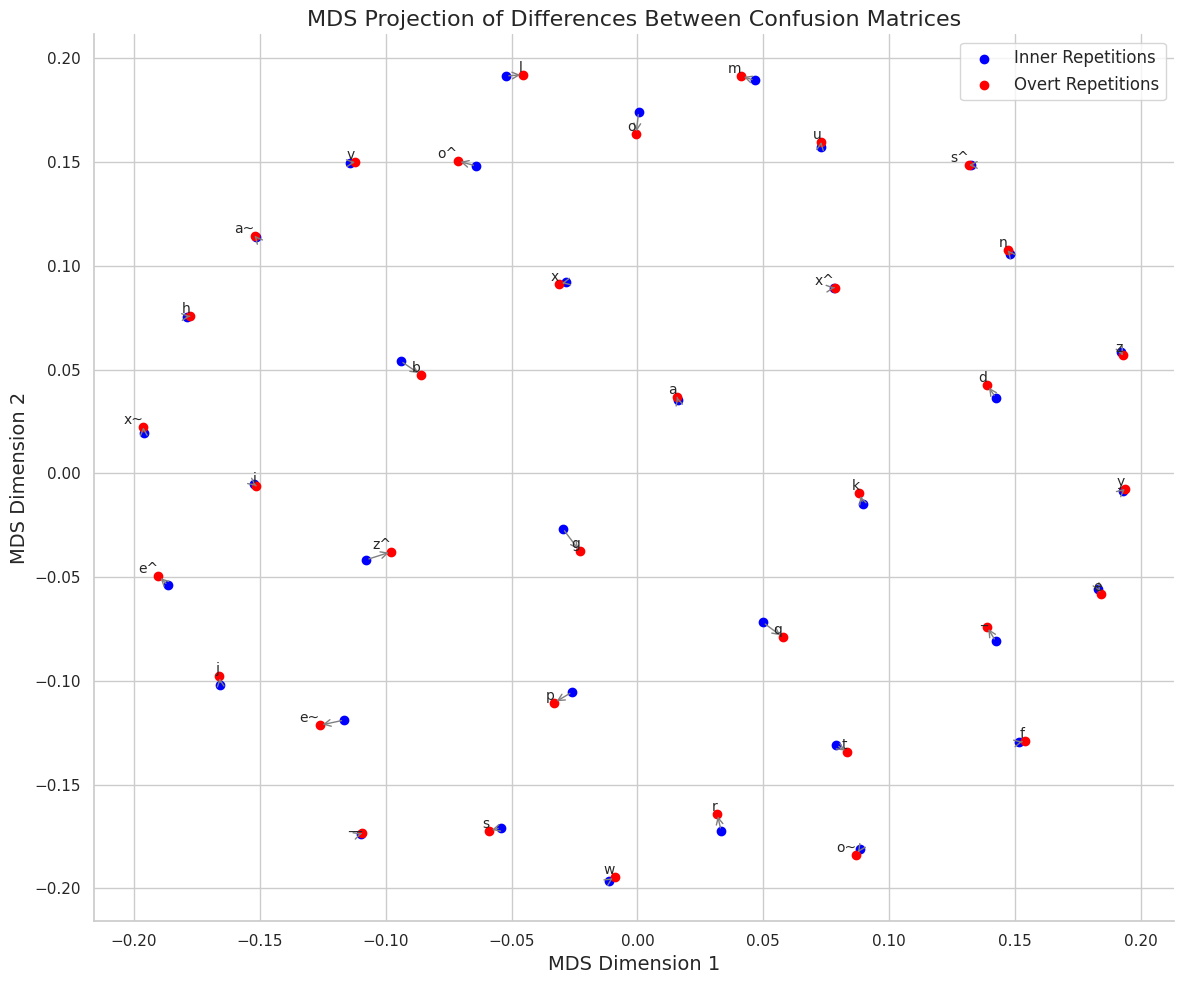

In [47]:
#######
# MDS #
#######

''' Visualizing Differences Between Confusion Matrices Using MDS '''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
from scipy.spatial import procrustes
import seaborn as sns

# Set the style for better aesthetics
sns.set(style='whitegrid')

# Paths to the confusion matrices
path_A = 'data/confusion_matrix_24_09/pb2007_speedx2_inner_estimations/cm_1/confusion_matrix.xlsx'
path_B = 'data/confusion_matrix_24_09/pb2007_speedx2_overt_repetitions/cm_1/confusion_matrix.xlsx'

# Function to load a confusion matrix from an Excel file
def load_confusion_matrix(path):
    return pd.read_excel(path, index_col=0).to_numpy()

# Load the confusion matrices
cm_A = load_confusion_matrix(path_A)
cm_B = load_confusion_matrix(path_B)

# Function to normalize a confusion matrix
def normalize_confusion_matrix(cm):
    epsilon = 1e-10  # Small constant to prevent division by zero
    cm = cm + epsilon
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    return cm_norm

# Normalize the confusion matrices
cm_A_norm = normalize_confusion_matrix(cm_A)
cm_B_norm = normalize_confusion_matrix(cm_B)

# Compute similarity matrices by symmetrizing the normalized confusion matrices
S_A = (cm_A_norm + cm_A_norm.T) / 2
S_B = (cm_B_norm + cm_B_norm.T) / 2

# Convert similarity matrices to distance matrices
D_A = 1 - S_A
D_B = 1 - S_B

# Perform MDS on the distance matrices
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
X_A = mds.fit_transform(D_A)
X_B = mds.fit_transform(D_B)

# Align the MDS configurations using Procrustes analysis
mtx1, mtx2, disparity = procrustes(X_A, X_B)

# Labels for the confusion matrix axes
labels = [
    "__", "a", "e^", "e", "i", "y", "u", "o^", "x", "x^", "a~", "e~", "x~", "o~",
    "p", "t", "k", "f", "s", "s^", "b", "d", "g", "v", "z", "z^", "m", "n",
    "r", "l", "w", "h", "j", "o", "q", "_"
]

# Plotting the MDS projections
fig, ax = plt.subplots(figsize=(12, 10))

# Plot positions from the first confusion matrix
ax.scatter(mtx1[:, 0], mtx1[:, 1], color='blue', label='Inner Repetitions')

# Plot positions from the second confusion matrix
ax.scatter(mtx2[:, 0], mtx2[:, 1], color='red', label='Overt Repetitions')

# Draw arrows showing shifts from mtx1 to mtx2
for i, label in enumerate(labels):
    ax.annotate('', xy=(mtx2[i, 0], mtx2[i, 1]), xytext=(mtx1[i, 0], mtx1[i, 1]),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1))
    ax.text(mtx2[i, 0], mtx2[i, 1], label, fontsize=10, ha='right', va='bottom')

# Set labels and title
ax.set_xlabel('MDS Dimension 1', fontsize=14)
ax.set_ylabel('MDS Dimension 2', fontsize=14)
ax.set_title('MDS Projection of Differences Between Confusion Matrices', fontsize=16)
ax.legend(fontsize=12)

# Remove top and right spines for a cleaner look
sns.despine()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
